# Three Bays Mangrove Timeseries Analysis, Artibonite, Haiti

In [1]:
import os
import gc
import json
import glob
import tarfile

import pandas as pd
import rasterio as rs
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from natsort import natsorted
from datetime import datetime
from sklearn.linear_model import LinearRegression

Getting and sorting .tar file paths from Bulk Download Landsat Ph.D Data directory

In [2]:
data_dir = 'F:/PhD Data/Landsat 2010-2022/*.tar'
tarpaths = []
# Suffixes and Prefixes to clean to easily sort by observation date 
sfs = ['_02_T1.tar','_02_T2.tar', '_02_T1_B1.TIF', '_02_T1_B2.TIF', '_02_T1_B3.TIF', '_02_T1_B4.TIF', '_02_T1_B5.TIF', '_02_T1_MTL.json',
        '_02_T2_B1.TIF', '_02_T2_B2.TIF', '_02_T2_B3.TIF', '_02_T2_B4.TIF', '_02_T2_B5.TIF', '_02_T2_MTL.json',
        '_02_T1_SR_B1.TIF', '_02_T1_SR_B2.TIF', '_02_T1_SR_B3.TIF', '_02_T1_SR_B4.TIF', '_02_T1_SR_B5.TIF', '_02_T1_MTL.json',
        '_02_T2_SR_B1.TIF', '_02_T2_SR_B2.TIF', '_02_T2_SR_B3.TIF', '_02_T2_SR_B4.TIF', '_02_T2_SR_B5.TIF', '_02_T2_MTL.json']
pfs = ['F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_', 
        'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009046_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LO08_L1GT_009047_',
        'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009046_', 'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009047_',
        'F:/PhD Data/Landsat 2010-2022\LE07_L2SP_009047_',
        'extracted/timeseries/LC08_L1GT_009047_', 'extracted/timeseries/LC08_L1TP_009047_', 
        'extracted/timeseries/LC08_L1TP_009046_', 'extracted/timeseries/LC08_L1GT_009047_',
        'extracted/timeseries/LC08_L2SP_009046_', 'extracted/timeseries/LC08_L2SP_009047_',
        'extracted/timeseries/LE07_L2SP_009047_']
# Parse through .tar files in folder
for filepath in glob.iglob(data_dir):
    tarpaths.append(filepath)

# Returns observation date
def rm_prefsuf(x):
    for sf in sfs:
        x = x.removesuffix(sf)
    for pf in pfs:
        x = x.removeprefix(pf)
    return (x)[:-9]

# Sort list of paths by observation dates
tarpaths = natsorted(tarpaths, key=lambda x: datetime.strptime(rm_prefsuf(x), '%Y%m%d'))

## Timeseries analysis

Extent of mangrove forest for cropping

In [3]:
bay_p = 'shapefiles/GP_mangrove_extent.shp'
bay_boundary = gpd.read_file(bay_p)

Retrieving .tar bands from all observations

In [4]:
rs.Env(VRT_SHARED_SOURCE = 0)

paths = []
# Only grab bands 1 through 5
wanted = ['B4.TIF', 'B5.TIF', 'MTL.json']
wanted_LS7 = ['B3.TIF', 'B4.TIF', 'MTL.json']

for tar in tarpaths:
    paths.append(tar)

Extract band files for temporary use (only Bands 1 to 5) and calculate NDVI for observation day

In [5]:
# First observation
ndvi_ts = []
ndvi_ts_max = []
ndvi_anim = []
dates = []
landsat7_path_pf = 'F:/PhD Data/Landsat 2010-2022\LE07'
for path in paths:
    current_date = datetime.strptime(rm_prefsuf(path), '%Y%m%d')
    archive1 = tarfile.open(path, 'r')
    archive1.getmembers()
    band_files = []
    for file in archive1.getmembers():
        #print(file.name + ': ' + str(file.name.endswith(tuple(wanted))))
        if path.startswith(landsat7_path_pf):
            if file.name.endswith(tuple(wanted_LS7)):
                band_files.append(file)
                file.uname
        else:
            if file.name.endswith(tuple(wanted)):
                band_files.append(file)
                file.uname
    band_files = natsorted(band_files, key=lambda x: x.name)

    # Bands extraction
    for f in band_files:
        archive1.extract(f, path='extracted/timeseries/')
        # Stack bands in list and open metadata
    bands = []
    directory = 'extracted/timeseries/'
        # Looping over all GeoTIFF files
    i = 0
    for entry in os.scandir(directory):
        entry_date = datetime.strptime(rm_prefsuf(entry.path), '%Y%m%d')
        # Tries to open .TIF files of the current obs date, if that fails, know we reached the .json metadata file and get that instead
        if entry_date == current_date:
            try:
                fp = entry.path
                # Open and crop bands to mangrove extent
                bands.append(rxr.open_rasterio(fp).rio.clip(bay_boundary.geometry, from_disk=True).squeeze())
                bands[i]["Band"] = i+1
                i += 1
            except Exception as e:
                i = 0
                metadata = json.load(open(entry.path))
    # Calculate NDVI for single observation date and stack
    nir = bands[1].astype(float)
    red = bands[0].astype(float)
    ndvi= (nir - red) / (nir + red)
    ndvi_anim.append(ndvi)
    dates.append(current_date)
    ndvi_ts.append(ndvi.mean().values)
    ndvi_ts_max.append(ndvi.max().values)

In [6]:
data = {'Date': dates,
        'Mean NDVI': ndvi_ts,
        'Max NDVI': ndvi_ts_max}
df = pd.DataFrame(data)
df = df.set_index("Date")
df['date_from_start'] = (df.index - df.index[0]).days

In [7]:
X = df['date_from_start'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, ndvi_ts)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
y = reg.predict(X)

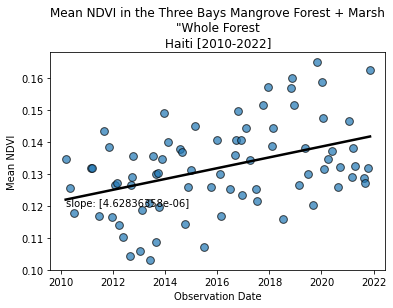

In [8]:
fig, ax = plt.subplots()
plt.scatter(dates, ndvi_ts, s=60, alpha=0.7, edgecolors="k")
b, a = np.polyfit(df['date_from_start'], ndvi_ts, deg=1)
xseq = df['date_from_start']
ax.plot(dates, a + b * xseq, color="k", lw=2.5);
#plt.plot(dates, y, color='red')
plt.title('Mean NDVI in the Three Bays Mangrove Forest\n"Whole Forest\nHaiti [2010-2022]')
plt.text(dates[0], 0.12, 'slope: ' + str(reg.coef_))
plt.xlabel('Observation Date')
plt.ylabel('Mean NDVI')
plt.show()

In [9]:
#for i, n in enumerate(ndvi_anim):
 #   fig = plt.figure(figsize=(8, 6), dpi=120)
 #   nd = plt.imshow(n, vmin=-1, vmax=1)
  #  plt.title("Baie de Grand-Pierre\n")
   # plt.set_cmap('seismic')
    #plt.colorbar(nd)
    #fig.savefig('animation/ndvi'+str(i)+'.png') 